# Preamble

In [1]:
!date

Thu Nov 21 07:18:56 PST 2024


In [2]:
%load_ext autoreload
%load_ext line_profiler

In [3]:
import logging

logging.basicConfig(level=logging.INFO, force=True)

In [4]:
import os as _os

_os.chdir(_os.environ["PROJECT_ROOT"])

In [5]:
import os
from contextlib import contextmanager
from itertools import chain, product
from multiprocessing import Pool

import fastcluster
import graph_tool as gt
import graph_tool.draw
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import strainzip as sz
import strainzip.app.unzip
import xarray as xr
from graph_tool.util import find_edge
from scipy.cluster.hierarchy import fcluster, linkage
from strainzip.pandas_util import idxwhere
from tqdm import tqdm

import lib.plot

# Params

## Plotting

In [6]:
mpl.rcParams["figure.dpi"] = 100
# sns.set_context('talk')

In [7]:
# Plotting parameters

length_bins = np.logspace(0, 6.5, num=51)
depth_bins = np.logspace(-1, 4, num=51)

draw_graphs = True

## Project params

In [8]:
k = 111
group = "btheta_mixture1_nopure"  # "btheta_mixture1_cov10000"
graph_type = f"k{k}-withmegahit3-droptips"
smoothing = "smoothed-6"
deconv = "norm-nobal-nocull-10-10"
clust_params = "e50-n20000-d20"
marker_model = "TIGR02013"

In [550]:
# benchmark = "all_ref_tiles-k10000-o6000"
benchmark = "all_ref_cds"


# Load Data

## Load Metadata

In [9]:
mgen_group = (
    pd.read_table("meta/mgen_group.tsv")[lambda x: x.mgen_group == group]
    .assign(community_id=lambda x: x.mgen_id.str.split("_simcom_").str[0])
    .set_index("mgen_id")
)
mgen_group

,mgen_group,community_id
mgen_id,,
btheta_mixture_50_50_simcom_len150_seed1_cov10000,btheta_mixture1_nopure,btheta_mixture_50_50
btheta_mixture_25_75_simcom_len150_seed2_cov10000,btheta_mixture1_nopure,btheta_mixture_25_75
btheta_mixture_75_25_simcom_len150_seed3_cov10000,btheta_mixture1_nopure,btheta_mixture_75_25
btheta_mixture_25_75_simcom_len150_seed4_cov10000,btheta_mixture1_nopure,btheta_mixture_25_75
btheta_mixture_75_25_simcom_len150_seed5_cov10000,btheta_mixture1_nopure,btheta_mixture_75_25


In [10]:
comm_fractions = (
    pd.read_table("meta/simulated_community.tsv")[
        lambda x: x.community_id.isin(mgen_group.community_id)
    ]
    .set_index(["community_id", "genome_id"])
    .fraction.unstack(fill_value=0)
)
sim_normalized_depth = (
    mgen_group[["community_id"]]
    .join(comm_fractions, on="community_id")
    .drop(columns=["community_id"])
    .rename_axis(index="sample")
)

assert sim_normalized_depth.sum(1).eq(1).all()

sim_normalized_depth

,Bacteroides-thetaiotaomicron-1-1-6_MAF-2,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2
sample,,
btheta_mixture_50_50_simcom_len150_seed1_cov10000,0.50,0.50
btheta_mixture_25_75_simcom_len150_seed2_cov10000,0.25,0.75
btheta_mixture_75_25_simcom_len150_seed3_cov10000,0.75,0.25
btheta_mixture_25_75_simcom_len150_seed4_cov10000,0.25,0.75
btheta_mixture_75_25_simcom_len150_seed5_cov10000,0.75,0.25


## Depth

### StrainZip

In [11]:
final_graph = sz.io.load_graph(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.{smoothing}.unzip-{deconv}.sz"
)

vertex_depth = (
    sz.results.depth_table(final_graph, final_graph.get_vertices())
    .T.rename_axis(index="vertex", columns="sample")
    .rename(columns=mgen_group.index.to_series().reset_index(drop=True))
)
vertex_depth

sample,btheta_mixture_50_50_simcom_len150_seed1_cov10000,btheta_mixture_25_75_simcom_len150_seed2_cov10000,btheta_mixture_75_25_simcom_len150_seed3_cov10000,btheta_mixture_25_75_simcom_len150_seed4_cov10000,btheta_mixture_75_25_simcom_len150_seed5_cov10000
vertex,,,,,
0,6.801172,4.939103,16.831335,4.587783,16.036444
1,19.566444,22.114233,21.471752,20.744485,22.505276
2,12.234105,4.589166,13.400909,1.992436,15.584103
3,21.819656,20.944447,21.215440,21.355111,20.673470
4,21.543179,22.325551,20.777233,20.590738,21.589073
...,...,...,...,...,...
5238,0.074498,0.317287,0.089019,0.061916,0.060605
5239,0.115512,0.113409,0.019483,0.015032,0.016279
5240,0.007476,0.004264,0.007578,0.003268,0.051514


### MEGAHIT/Bowtie2

In [64]:
megahit_gene_depth = pd.read_table(
    f"data/group/{group}/r.proc.megahit-full-k111.prodigal.gene_depth.tsv",
    names=["sample", "gene", "depth"],
    index_col=["sample", "gene"],
).depth.unstack("sample", fill_value=0)

In [65]:
megahit_contig_depth = pd.read_table(
    f"data/group/{group}/r.proc.megahit-full-k111.contig_depth.tsv",
    names=["sample", "contig", "depth"],
    index_col=["sample", "contig"],
).depth.unstack("sample", fill_value=0)

## Genes

### StrainZip

In [66]:
strainzip_gene = pd.read_table(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.{smoothing}.unzip-{deconv}.contigs-d0.prodigal.bed",
    names=["vertex", "left", "right", "gene", "score", "strand"],
)
strainzip_gene

,vertex,left,right,gene,score,strand
0,0,0,219,0[0-219]+,0,+
1,1,18,213,1[18-213]+,0,+
2,10,1,82,10[1-82]+,0,+
3,10,93,273,10[93-273]+,0,+
4,100,2,155,100[2-155]-,0,-
...,...,...,...,...,...,...
51425,995,0,132,995[0-132]+,0,+
51426,995,137,383,995[137-383]+,0,+
51427,997,2,221,997[2-221]-,0,-
51428,998,2,248,998[2-248]-,0,-


In [67]:
strainzip_marker_gene_list = pd.read_table(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.{smoothing}.unzip-{deconv}.contigs-d0.cds.tran.hmmer-{marker_model}-ga.tsv",
    names=["gene", "gene_name", "bitscore"],
).gene.tolist()


print(strainzip_marker_gene_list)

total_strainzip_marker_depth = vertex_depth.loc[
    strainzip_gene[lambda x: x.gene.isin(strainzip_marker_gene_list)].vertex
].sum()
total_strainzip_marker_depth

['2754[1320-4935]-', '2761[0-3615]+', '2811[0-2667]+', '2968[2-2669]-', '3126[2-2669]-', '3132[0-2667]+', '3294[0-2667]+', '3547[2-2669]-']


sample
btheta_mixture_50_50_simcom_len150_seed1_cov10000    42.472616
btheta_mixture_25_75_simcom_len150_seed2_cov10000    41.574192
btheta_mixture_75_25_simcom_len150_seed3_cov10000    42.081190
btheta_mixture_25_75_simcom_len150_seed4_cov10000    42.900954
btheta_mixture_75_25_simcom_len150_seed5_cov10000    40.799988
dtype: float64

In [68]:
strainzip_normalized_depth = (vertex_depth / total_strainzip_marker_depth).T
strainzip_normalized_depth

vertex,0,1,2,3,4,5,6,7,8,9,...,5233,5234,5235,5236,5237,5238,5239,5240,5241,5242
sample,,,,,,,,,,,,,,,,,,,,,
btheta_mixture_50_50_simcom_len150_seed1_cov10000,0.160131,0.460684,0.288047,0.513735,0.507225,0.502109,0.515322,0.291773,0.522401,0.225729,...,0.000423,0.005113,0.001891,0.005112,0.004582,0.001754,0.002720,0.000176,0.000005,0.237117
btheta_mixture_25_75_simcom_len150_seed2_cov10000,0.118802,0.531922,0.110385,0.503785,0.537005,0.523716,0.496232,0.112450,0.537826,0.147630,...,0.005036,0.000939,0.002021,0.000939,0.000106,0.007632,0.002728,0.000103,0.000034,0.125300
btheta_mixture_75_25_simcom_len150_seed3_cov10000,0.399973,0.510246,0.318454,0.504155,0.493742,0.493024,0.486555,0.349746,0.495931,0.399731,...,0.001010,0.002426,0.000716,0.002427,0.000207,0.002115,0.000463,0.000180,0.000014,0.363994
btheta_mixture_25_75_simcom_len150_seed4_cov10000,0.106939,0.483544,0.046443,0.497777,0.479960,0.493544,0.519739,0.156951,0.480598,0.138926,...,0.000266,0.001236,0.000559,0.001237,0.000101,0.001443,0.000350,0.000076,0.011135,0.126334
btheta_mixture_75_25_simcom_len150_seed5_cov10000,0.393050,0.551600,0.381963,0.506703,0.529144,0.530334,0.532701,0.379667,0.522979,0.429775,...,0.000695,0.001096,0.001189,0.001096,0.000268,0.001485,0.000399,0.001263,0.003206,0.383442


### MEGAHIT/Bowtie2

In [69]:
megahit_gene = pd.read_table(
    f"data/group/{group}/r.proc.megahit-full-k111.prodigal.bed",
    names=["vertex", "left", "right", "gene", "score", "strand"],
)
megahit_gene

,vertex,left,right,gene,score,strand
0,k111_0,2,1079,k111_0[2-1079]-,0,-
1,k111_0,1178,2852,k111_0[1178-2852]-,0,-
2,k111_0,2876,4697,k111_0[2876-4697]-,0,-
3,k111_0,4703,5396,k111_0[4703-5396]+,0,+
4,k111_0,5636,7298,k111_0[5636-7298]+,0,+
...,...,...,...,...,...,...
7354,k111_997,15372,16212,k111_997[15372-16212]+,0,+
7355,k111_997,16300,16882,k111_997[16300-16882]+,0,+
7356,k111_997,16985,17342,k111_997[16985-17342]+,0,+
7357,k111_998,2,446,k111_998[2-446]+,0,+


In [70]:
megahit_marker_gene_list = pd.read_table(
    f"data/group/{group}/r.proc.megahit-full-k111.cds.tran.hmmer-{marker_model}-ga.tsv",
    names=["gene", "gene_name", "bitscore"],
).gene.tolist()


print(megahit_marker_gene_list)

total_megahit_marker_depth = megahit_gene_depth.loc[
    megahit_gene[lambda x: x.gene.isin(megahit_marker_gene_list)].gene
].sum()
total_megahit_marker_depth

['k111_647[9786-13599]+']


sample
btheta_mixture_25_75_simcom_len150_seed2_cov10000    97.841332
btheta_mixture_25_75_simcom_len150_seed4_cov10000    99.727511
btheta_mixture_50_50_simcom_len150_seed1_cov10000    96.694466
btheta_mixture_75_25_simcom_len150_seed3_cov10000    99.458694
btheta_mixture_75_25_simcom_len150_seed5_cov10000    97.279832
dtype: float64

In [71]:
megahit_normalized_depth = (megahit_contig_depth / total_megahit_marker_depth).T
megahit_normalized_depth

contig,k111_0,k111_10,k111_100,k111_1000,k111_1001,k111_1002,k111_1003,k111_1004,k111_1005,k111_1006,...,k111_990,k111_991,k111_992,k111_993,k111_994,k111_995,k111_996,k111_997,k111_998,k111_999
sample,,,,,,,,,,,,,,,,,,,,,
btheta_mixture_25_75_simcom_len150_seed2_cov10000,1.009254,0.999910,0.016940,0.260115,1.020570,0.398120,0.267581,0.534798,1.011454,1.496239,...,0.174655,0.602721,0.122648,0.486054,0.249982,0.103323,0.782148,1.026632,0.222933,0.019309
btheta_mixture_25_75_simcom_len150_seed4_cov10000,0.996516,0.972715,0.012465,0.254218,0.987358,0.427847,0.214826,0.424097,0.982144,1.463428,...,0.222241,0.701285,0.111041,0.488748,0.252405,0.099157,0.866813,0.992530,0.225424,0.007577
btheta_mixture_50_50_simcom_len150_seed1_cov10000,0.987462,0.684792,0.004285,0.494106,0.802495,0.186287,0.137793,0.287675,1.031400,2.147351,...,0.413230,0.542372,0.095463,0.306979,0.384891,0.269976,0.738160,1.001654,0.104112,0.003908
btheta_mixture_75_25_simcom_len150_seed3_cov10000,1.002196,0.989932,0.016665,0.763512,1.000552,0.129873,0.072945,0.144519,0.988641,3.001437,...,0.574531,0.524286,0.046405,0.201807,0.775397,0.361586,0.778033,1.005644,0.070853,0.011397
btheta_mixture_75_25_simcom_len150_seed5_cov10000,1.010755,1.024063,0.000000,0.800651,1.018127,0.124508,0.052841,0.121399,1.012001,2.988163,...,0.547079,0.549762,0.080655,0.131520,0.788507,0.360974,0.863822,1.017602,0.082789,0.023304


# Sequence Matching

## BLASTn

In [562]:
benchmark_sequence_length = pd.read_table(
    f"data/group/{group}/{benchmark}.benchmark_sequences.nlength.tsv",
    names=["gene", "nlength"],
    index_col="gene",
).nlength
benchmark_sequence_length

gene
Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[0-1413]+            1413
Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1554-2292]-          738
Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[2576-5114]+         2538
Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[5245-7927]+         2682
Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[8139-9153]+         1014
                                                               ... 
Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[30017-30524]-     507
Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[30528-31236]-     708
Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[31246-31456]-     210
Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[31442-32009]-     567
Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[31992-33039]-    1047
Name: nlength, Length: 10536, dtype: int64

In [563]:
blastn_columns = [
    # Thanks ChatGPT.
    "qseqid",  # Query sequence ID
    "sseqid",  # Subject sequence ID
    "pident",  # Percentage of identical matches
    "length",  # Alignment length
    "mismatch",  # Number of mismatches
    "gapopen",  # Number of gap openings
    "qstart",  # Start of alignment in query
    "qend",  # End of alignment in query
    "sstart",  # Start of alignment in subject
    "send",  # End of alignment in subject
    "evalue",  # Expect value
    "bitscore",  # Bit score
]

### Ref

In [564]:
match_ref = (
    pd.read_table(
        f"data/group/{group}/all_refs.bench-{benchmark}-blastn.tsv",
        names=blastn_columns,
    )
    .join(benchmark_sequence_length.rename("qlen"), on="qseqid")
    .assign(
        identity=lambda x: x.pident / 100,
        qcoverage=lambda x: x.length / x.qlen,
        qleft=lambda x: x.qstart - 1,
        sleft=lambda x: x.sstart - 1,
        qright=lambda x: x.qend,
        sright=lambda x: x.send,
        genome=lambda x: x.sseqid.str.rsplit("_", n=1).str[
            0
        ],  # Equivalent to the "vertex" field for the strainzip_match and megahit_match tables. I'll join depths based on this.
    )
)

match_ref

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,qlen,identity,qcoverage,qleft,sleft,qright,sright,genome
0,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[0-1...,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1,100.000,1413,0,0,1,1413,1,1413,0.000000e+00,2610.0,1413,1.00000,1.0,0,0,1413,1413,Bacteroides-thetaiotaomicron-1-1-6_MAF-2
1,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[0-1...,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_1,99.788,1413,3,0,1,1413,1,1413,0.000000e+00,2593.0,1413,0.99788,1.0,0,0,1413,1413,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2
2,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[155...,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1,100.000,738,0,0,1,738,2292,1555,0.000000e+00,1363.0,738,1.00000,1.0,0,2291,738,1555,Bacteroides-thetaiotaomicron-1-1-6_MAF-2
3,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[155...,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_1,99.322,738,5,0,1,738,2236,1499,0.000000e+00,1336.0,738,0.99322,1.0,0,2235,738,1499,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2
4,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[257...,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1,100.000,2538,0,0,1,2538,2577,5114,0.000000e+00,4687.0,2538,1.00000,1.0,0,2576,2538,5114,Bacteroides-thetaiotaomicron-1-1-6_MAF-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22702,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[...,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_3,100.000,210,0,0,1,210,18260,18469,2.080000e-108,388.0,210,1.00000,1.0,0,18259,210,18469,Bacteroides-thetaiotaomicron-1-1-6_MAF-2
22703,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[...,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2,100.000,567,0,0,1,567,32009,31443,0.000000e+00,1048.0,567,1.00000,1.0,0,32008,567,31443,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2
22704,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[...,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_3,99.824,567,1,0,1,567,17707,18273,0.000000e+00,1042.0,567,0.99824,1.0,0,17706,567,18273,Bacteroides-thetaiotaomicron-1-1-6_MAF-2
22705,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[...,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2,100.000,1047,0,0,1,1047,33039,31993,0.000000e+00,1934.0,1047,1.00000,1.0,0,33038,1047,31993,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2


### StrainZip

In [565]:
match_strainzip = (
    pd.read_table(
        f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.{smoothing}.unzip-{deconv}.contigs-d0.bench-{benchmark}-blastn.tsv",
        names=blastn_columns,
    )
    .join(benchmark_sequence_length.rename("qlen"), on="qseqid")
    .assign(
        identity=lambda x: x.pident / 100,
        qcoverage=lambda x: x.length / x.qlen,
        qleft=lambda x: x.qstart - 1,
        sleft=lambda x: x.sstart - 1,
        qright=lambda x: x.qend,
        sright=lambda x: x.send,
        vertex=lambda x: x.sseqid,  # Equivalent to the "genome" field for the ref_match table. I'll join depths based on this.
    )
)

match_strainzip  # [lambda x: (x.qcoverage >= min_coverage) & (x.identity >= min_identity)]

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,qlen,identity,qcoverage,qleft,sleft,qright,sright,vertex
0,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[0-1...,384,100.0,817,0,0,2,818,1,817,0.0,1509.0,1413,1.0,0.578202,1,0,818,817,384
1,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[0-1...,640,100.0,817,0,0,2,818,817,1,0.0,1509.0,1413,1.0,0.578202,1,816,818,1,640
2,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[0-1...,2285,100.0,705,0,0,709,1413,1,705,0.0,1303.0,1413,1.0,0.498938,708,0,1413,705,2285
3,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[0-1...,3470,100.0,705,0,0,709,1413,3337,2633,0.0,1303.0,1413,1.0,0.498938,708,3336,1413,2633,3470
4,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[0-1...,2227,100.0,705,0,0,709,1413,3337,2633,0.0,1303.0,1413,1.0,0.498938,708,3336,1413,2633,2227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110515,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[...,2357,100.0,1047,0,0,1,1047,8898,7852,0.0,1934.0,1047,1.0,1.000000,0,8897,1047,7852,2357
110516,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[...,2284,100.0,1047,0,0,1,1047,15545,16591,0.0,1934.0,1047,1.0,1.000000,0,15544,1047,16591,2284
110517,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[...,2191,100.0,1047,0,0,1,1047,8874,7828,0.0,1934.0,1047,1.0,1.000000,0,8873,1047,7828,2191
110518,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[...,1981,100.0,1047,0,0,1,1047,13480,14526,0.0,1934.0,1047,1.0,1.000000,0,13479,1047,14526,1981


### MEGAHIT

In [566]:
match_megahit = (
    pd.read_table(
        f"data/group/{group}/r.proc.megahit-full-k111.bench-{benchmark}-blastn.tsv",
        names=blastn_columns,
    )
    .join(benchmark_sequence_length.rename("qlen"), on="qseqid")
    .assign(
        identity=lambda x: x.pident / 100,
        qcoverage=lambda x: x.length / x.qlen,
        qleft=lambda x: x.qstart - 1,
        sleft=lambda x: x.sstart - 1,
        qright=lambda x: x.qend,
        sright=lambda x: x.send,
        vertex=lambda x: x.sseqid,  # Equivalent to the "genome" field for the ref_match table. I'll join depths based on this.
    )
)

match_megahit  # [lambda x: (x.qcoverage >= min_coverage) & (x.identity >= min_identity)]

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,qlen,identity,qcoverage,qleft,sleft,qright,sright,vertex
0,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[0-1...,k111_1323,99.788,1412,3,0,2,1413,19310,17899,0.000000e+00,2591.0,1413,0.99788,0.999292,1,19309,1413,17899,k111_1323
1,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[155...,k111_1323,99.458,738,4,0,1,738,17076,17813,0.000000e+00,1341.0,738,0.99458,1.000000,0,17075,738,17813,k111_1323
2,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[257...,k111_1323,99.724,2538,7,0,1,2538,16791,14254,0.000000e+00,4649.0,2538,0.99724,1.000000,0,16790,2538,14254,k111_1323
3,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[524...,k111_1323,100.000,2682,0,0,1,2682,14122,11441,0.000000e+00,4953.0,2682,1.00000,1.000000,0,14121,2682,11441,k111_1323
4,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[813...,k111_1323,100.000,1014,0,0,1,1014,11228,10215,0.000000e+00,1873.0,1014,1.00000,1.000000,0,11227,1014,10215,k111_1323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15103,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[...,k111_1060,99.606,507,2,0,1,507,25123,25629,0.000000e+00,926.0,507,0.99606,1.000000,0,25122,507,25629,k111_1060
15104,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[...,k111_1060,100.000,708,0,0,1,708,24411,25118,0.000000e+00,1308.0,708,1.00000,1.000000,0,24410,708,25118,k111_1060
15105,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[...,k111_1060,100.000,210,0,0,1,210,24191,24400,1.260000e-108,388.0,210,1.00000,1.000000,0,24190,210,24400,k111_1060
15106,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[...,k111_1060,100.000,567,0,0,1,567,23638,24204,0.000000e+00,1048.0,567,1.00000,1.000000,0,23637,567,24204,k111_1060


# Depth Error

## Match Params

In [567]:
min_identity = 0.98
min_coverage = 0.95

## Expect

In [568]:
bench_x_genome = (
    match_ref[lambda x: (x.qcoverage >= min_coverage) & (x.identity >= min_identity)][
        ["qseqid", "genome"]
    ]
    .value_counts()
    .unstack("genome", fill_value=0)
)
bench_x_genome

genome,Bacteroides-thetaiotaomicron-1-1-6_MAF-2,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2
qseqid,,
Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[0-1413]+,1,1
Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1000131-1003038]+,1,1
Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1003224-1006041]+,1,1
Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1006208-1007141]+,1,1
Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1007297-1009148]-,1,1
...,...,...
Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[5680-5968]-,1,1
Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[6231-7671]-,1,1
Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[7672-9922]-,1,1


In [570]:
bench_sim_depth = sim_normalized_depth @ bench_x_genome.T
bench_sim_depth

qseqid,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[0-1413]+,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1000131-1003038]+,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1003224-1006041]+,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1006208-1007141]+,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1007297-1009148]-,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1009274-1010261]+,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1010342-1011959]-,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[101180-101867]+,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1012133-1013381]+,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1014035-1014953]+,...,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[31246-31456]-,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[31442-32009]-,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[31992-33039]-,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[46-937]-,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[5378-5681]-,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[5680-5968]-,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[6231-7671]-,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[7672-9922]-,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[941-1586]-,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[9926-10547]-
sample,,,,,,,,,,,,,,,,,,,,,
btheta_mixture_50_50_simcom_len150_seed1_cov10000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.50,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
btheta_mixture_25_75_simcom_len150_seed2_cov10000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.25,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
btheta_mixture_75_25_simcom_len150_seed3_cov10000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.75,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
btheta_mixture_25_75_simcom_len150_seed4_cov10000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.25,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
btheta_mixture_75_25_simcom_len150_seed5_cov10000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.75,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## StrainZip

In [571]:
bench_x_strainzip = (
    match_strainzip[
        lambda x: (x.qcoverage >= min_coverage) & (x.identity >= min_identity)
    ][["qseqid", "vertex"]]
    .value_counts()
    .unstack("vertex", fill_value=0)
)
bench_x_strainzip

vertex,21,36,63,77,88,107,112,118,124,144,...,5233,5234,5235,5236,5237,5238,5239,5240,5241,5242
qseqid,,,,,,,,,,,,,,,,,,,,,
Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1003224-1006041]+,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1006208-1007141]+,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1007297-1009148]-,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1009274-1010261]+,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1010342-1011959]-,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[5680-5968]-,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[6231-7671]-,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[7672-9922]-,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [572]:
_normalized_vertex_depth = (
    (vertex_depth / total_strainzip_marker_depth)
    .reindex(bench_x_strainzip.columns, fill_value=0)
    .T
)
_normalized_vertex_depth

vertex,21,36,63,77,88,107,112,118,124,144,...,5233,5234,5235,5236,5237,5238,5239,5240,5241,5242
sample,,,,,,,,,,,,,,,,,,,,,
btheta_mixture_50_50_simcom_len150_seed1_cov10000,0.490530,0.499311,0.750537,0.499013,0.482211,0.256548,5.156989,2.233664,0.496051,0.475208,...,0.000423,0.005113,0.001891,0.005112,0.004582,0.001754,0.002720,0.000176,0.000005,0.237117
btheta_mixture_25_75_simcom_len150_seed2_cov10000,0.503365,0.495007,0.370369,0.483853,0.482340,0.128294,2.623302,1.140947,0.501455,0.476813,...,0.005036,0.000939,0.002021,0.000939,0.000106,0.007632,0.002728,0.000103,0.000034,0.125300
btheta_mixture_75_25_simcom_len150_seed3_cov10000,0.518512,0.497531,1.145115,0.501187,0.517530,0.395060,7.896160,3.396945,0.499223,0.413466,...,0.001010,0.002426,0.000716,0.002427,0.000207,0.002115,0.000463,0.000180,0.000014,0.363994
btheta_mixture_25_75_simcom_len150_seed4_cov10000,0.485519,0.482454,0.357617,0.486996,0.487999,0.125747,2.507662,1.148346,0.491253,0.462915,...,0.000266,0.001236,0.000559,0.001237,0.000101,0.001443,0.000350,0.000076,0.011135,0.126334
btheta_mixture_75_25_simcom_len150_seed5_cov10000,0.509710,0.555966,1.193999,0.514151,0.492322,0.395772,8.160077,3.600298,0.519369,0.452174,...,0.000695,0.001096,0.001189,0.001096,0.000268,0.001485,0.000399,0.001263,0.003206,0.383442


In [573]:
bench_strainzip_depth = _normalized_vertex_depth @ bench_x_strainzip.T
bench_strainzip_depth

qseqid,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1003224-1006041]+,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1006208-1007141]+,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1007297-1009148]-,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1009274-1010261]+,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1010342-1011959]-,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[101180-101867]+,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1012133-1013381]+,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1014035-1014953]+,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1015472-1018538]+,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1018577-1020203]+,...,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[31246-31456]-,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[31442-32009]-,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[31992-33039]-,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[46-937]-,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[5378-5681]-,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[5680-5968]-,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[6231-7671]-,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[7672-9922]-,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[941-1586]-,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[9926-10547]-
sample,,,,,,,,,,,,,,,,,,,,,
btheta_mixture_50_50_simcom_len150_seed1_cov10000,1.007583,0.244089,0.983590,0.983590,0.983590,0.532208,0.983590,0.493524,0.983590,0.983590,...,1.000767,1.000767,1.000767,1.000767,1.000767,1.000767,1.000767,1.000767,1.000767,1.000767
btheta_mixture_25_75_simcom_len150_seed2_cov10000,1.020131,0.381877,1.036212,1.036212,1.036212,0.263771,1.036212,0.286023,1.036212,1.036212,...,1.020671,1.020671,1.020671,1.020671,1.020671,1.020671,1.020671,1.020671,1.020671,1.020671
btheta_mixture_75_25_simcom_len150_seed3_cov10000,1.025345,0.132069,1.010471,1.010471,1.010471,0.745932,1.010471,0.749458,1.010471,1.010471,...,1.016115,1.016115,1.016115,1.016115,1.016115,1.016115,1.016115,1.016115,1.016115,1.016115
btheta_mixture_25_75_simcom_len150_seed4_cov10000,1.002003,0.374932,0.989162,0.989162,0.989162,0.251957,0.989162,0.246512,0.989162,0.989162,...,1.003919,1.003919,1.003919,1.003919,1.003919,1.003919,1.003919,1.003919,1.003919,1.003919
btheta_mixture_75_25_simcom_len150_seed5_cov10000,1.042220,0.130754,1.075195,1.075195,1.075195,0.768932,1.075195,0.809662,1.075195,1.075195,...,1.026470,1.026470,1.026470,1.026470,1.026470,1.026470,1.026470,1.026470,1.026470,1.026470


(array([6.8000e+01, 0.0000e+00, 3.4000e+01, 0.0000e+00, 0.0000e+00,
        6.8000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.2000e+01, 0.0000e+00, 0.0000e+00, 2.4000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2000e+01, 0.0000e+00,
        0.0000e+00, 1.8000e+01, 0.0000e+00, 2.4000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 6.0000e+00, 0.0000e+00, 0.0000e+00, 2.8000e+01,
        0.0000e+00, 6.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 8.0000e+00,
        0.0000e+00, 0.0000e+00, 1.8000e+01, 0.0000e+00, 0.0000e+00,
        4.0000e+00, 0.0000e+00, 4.0000e+00, 0.0000e+00, 0.0000e+00,
        1.8000e+01, 0.0000e+00, 4.6000e+01, 0.0000e+00, 0.0000e+00,
        4.0000e+00, 0.0000e+00, 0.0000e+00, 2.00

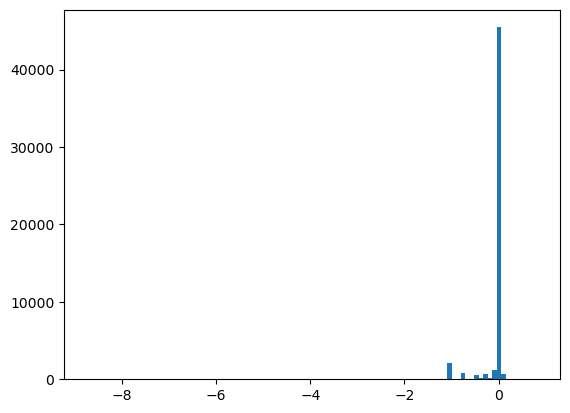

In [574]:
y_est = bench_strainzip_depth
y_true = bench_sim_depth

y_est, y_true = y_est.align(y_true, fill_value=0)

strainzip_error = y_est - y_true

# bins = np.linspace(-10, 10, num=100)
bins = 100
plt.hist(strainzip_error.stack(), bins=bins)
# plt.yscale('log')

<Axes: xlabel='qseqid', ylabel='sample'>

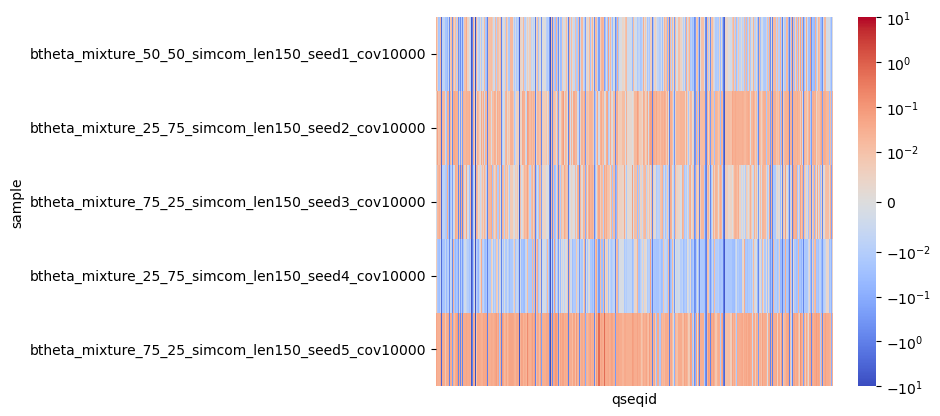

In [575]:
sns.heatmap(
    strainzip_error,
    cmap="coolwarm",
    norm=mpl.colors.SymLogNorm(0.01, vmin=-10, vmax=10),
    xticklabels=0,
)

## MEGAHIT

In [576]:
bench_x_megahit = (
    match_megahit[
        lambda x: (x.qcoverage >= min_coverage) & (x.identity >= min_identity)
    ][["qseqid", "vertex"]]
    .value_counts()
    .unstack("vertex", fill_value=0)
)
bench_x_megahit

vertex,k111_0,k111_10,k111_1000,k111_1001,k111_1005,k111_1006,k111_101,k111_1010,k111_1012,k111_1013,...,k111_966,k111_967,k111_968,k111_975,k111_976,k111_98,k111_980,k111_99,k111_994,k111_997
qseqid,,,,,,,,,,,,,,,,,,,,,
Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[0-1413]+,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1000131-1003038]+,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1003224-1006041]+,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1006208-1007141]+,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1007297-1009148]-,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[5680-5968]-,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[6231-7671]-,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[7672-9922]-,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [577]:
_normalized_contig_depth = (
    (megahit_contig_depth / total_megahit_marker_depth)
    .reindex(bench_x_megahit.columns, fill_value=0)
    .T
)
_normalized_contig_depth

vertex,k111_0,k111_10,k111_1000,k111_1001,k111_1005,k111_1006,k111_101,k111_1010,k111_1012,k111_1013,...,k111_966,k111_967,k111_968,k111_975,k111_976,k111_98,k111_980,k111_99,k111_994,k111_997
sample,,,,,,,,,,,,,,,,,,,,,
btheta_mixture_25_75_simcom_len150_seed2_cov10000,1.009254,0.999910,0.260115,1.020570,1.011454,1.496239,0.763766,0.261016,0.313521,1.016907,...,0.433279,0.221278,0.586973,0.405666,4.624763,0.683164,0.749436,1.035748,0.249982,1.026632
btheta_mixture_25_75_simcom_len150_seed4_cov10000,0.996516,0.972715,0.254218,0.987358,0.982144,1.463428,0.741061,0.261158,0.300319,0.996392,...,0.468733,0.245442,0.652823,0.396321,4.678328,0.685793,0.722663,1.012920,0.252405,0.992530
btheta_mixture_50_50_simcom_len150_seed1_cov10000,0.987462,0.684792,0.494106,0.802495,1.031400,2.147351,0.397807,0.481615,0.552109,0.955051,...,0.351788,0.293178,0.181054,0.584437,4.694447,0.222946,0.483415,0.642908,0.384891,1.001654
btheta_mixture_75_25_simcom_len150_seed3_cov10000,1.002196,0.989932,0.763512,1.000552,0.988641,3.001437,0.242535,0.751304,0.818674,0.987875,...,0.854841,0.725815,0.238221,0.770730,4.674755,0.214494,0.216972,0.934306,0.775397,1.005644
btheta_mixture_75_25_simcom_len150_seed5_cov10000,1.010755,1.024063,0.800651,1.018127,1.012001,2.988163,0.240138,0.759774,0.797257,1.045664,...,0.807759,0.696891,0.187361,0.766437,4.698949,0.257496,0.228725,0.965538,0.788507,1.017602


In [578]:
bench_megahit_depth = _normalized_contig_depth @ bench_x_megahit.T
bench_megahit_depth

qseqid,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[0-1413]+,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1000131-1003038]+,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1003224-1006041]+,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1006208-1007141]+,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1007297-1009148]-,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1009274-1010261]+,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1010342-1011959]-,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[101180-101867]+,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1012133-1013381]+,Bacteroides-thetaiotaomicron-1-1-6_MAF-2_1[1014035-1014953]+,...,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[31246-31456]-,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[31442-32009]-,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[31992-33039]-,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[46-937]-,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[5378-5681]-,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[5680-5968]-,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[6231-7671]-,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[7672-9922]-,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[941-1586]-,Bacteroides-thetaiotaomicron-VPI-5482_MAF-2_2[9926-10547]-
sample,,,,,,,,,,,,,,,,,,,,,
btheta_mixture_25_75_simcom_len150_seed2_cov10000,0.996682,1.021245,1.021245,1.021245,1.021245,1.021245,1.021245,1.037813,1.021245,1.021245,...,1.004756,1.004756,1.004756,1.004756,1.004756,1.004756,1.004756,1.004756,1.004756,1.004756
btheta_mixture_25_75_simcom_len150_seed4_cov10000,1.001830,0.993419,0.993419,0.993419,0.993419,0.993419,0.993419,0.987234,0.993419,0.993419,...,0.988503,0.988503,0.988503,0.988503,0.988503,0.988503,0.988503,0.988503,0.988503,0.988503
btheta_mixture_50_50_simcom_len150_seed1_cov10000,0.755131,0.892380,0.892380,0.892380,0.892380,0.892380,0.892380,0.977108,0.892380,0.892380,...,1.012586,1.012586,1.012586,1.012586,1.012586,1.012586,1.012586,1.012586,1.012586,1.012586
btheta_mixture_75_25_simcom_len150_seed3_cov10000,0.998456,1.001505,1.001505,1.001505,1.001505,1.001505,1.001505,0.997313,1.001505,1.001505,...,0.990972,0.990972,0.990972,0.990972,0.990972,0.990972,0.990972,0.990972,0.990972,0.990972
btheta_mixture_75_25_simcom_len150_seed5_cov10000,1.022538,1.058462,1.058462,1.058462,1.058462,1.058462,1.058462,1.027242,1.058462,1.058462,...,1.017595,1.017595,1.017595,1.017595,1.017595,1.017595,1.017595,1.017595,1.017595,1.017595


(array([3.6000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.8000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0800e+02, 1.8000e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.8000e+01, 1.0000e+01,
        0.0000e+00, 1.1000e+01, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        2.0000e+00, 4.0000e+01, 2.8000e+01, 8.00

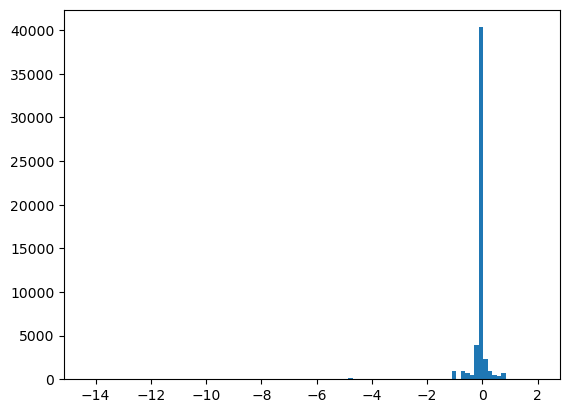

In [579]:
y_est = bench_megahit_depth
y_true = bench_sim_depth

y_est, y_true = y_est.align(y_true, fill_value=0)

megahit_error = y_est - y_true

# bins = np.linspace(-10, 10, num=100)
bins = 100
plt.hist(megahit_error.stack(), bins=bins)
# plt.yscale('log')

<Axes: xlabel='qseqid', ylabel='sample'>

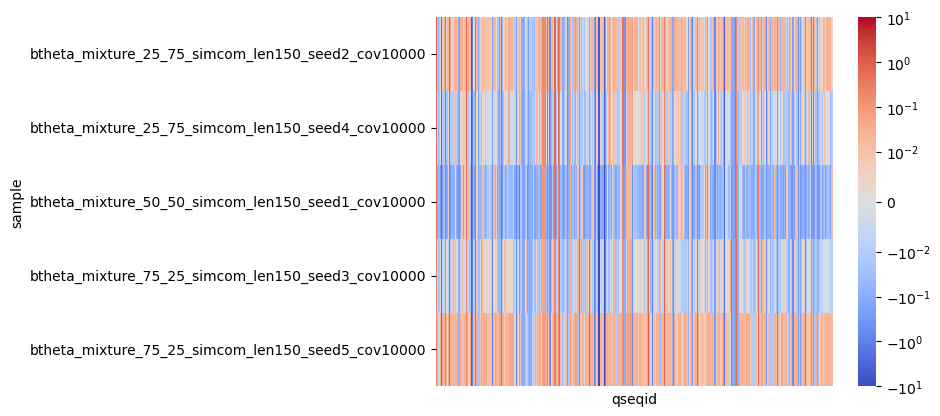

In [580]:
sns.heatmap(
    megahit_error,
    cmap="coolwarm",
    norm=mpl.colors.SymLogNorm(0.01, vmin=-10, vmax=10),
    xticklabels=0,
)

## Effect of matching threshold

In [583]:
def predict_depth_from_match_and_weight(match, weight, selector):
    dictionary = match[selector][["key", "qseqid"]].value_counts().unstack()
    return weight @ dictionary.reindex(weight.columns).fillna(0)


thresh_list = [
    ("0_identical", 1.0, 0.9),
    ("1_high", 0.999, 0.9),
    ("2_medium", 0.99, 0.9),
    ("3_low", 0.97, 0.9),
    ("4_verylow", 0.95, 0.9),
]

In [584]:
error = []
for thresh_name, _min_identity, _min_coverage in thresh_list:
    _selector = lambda x: (x.identity >= _min_identity) & (x.qcoverage >= _min_coverage)

    _ref_pred = predict_depth_from_match_and_weight(
        match=match_ref.assign(key=lambda x: x.genome),
        weight=sim_normalized_depth,
        selector=_selector,
    )

    for tool_name, match, weight in [
        (
            "strainzip",
            match_strainzip.assign(key=lambda x: x.vertex),
            strainzip_normalized_depth,
        ),
        (
            "megahit",
            match_megahit.assign(key=lambda x: x.vertex),
            megahit_normalized_depth,
        ),
    ]:
        _tool_pred = predict_depth_from_match_and_weight(
            match=match,
            weight=weight,
            selector=_selector,
        )

        x0, y0 = _ref_pred.align(_tool_pred, fill_value=0)
        for sample in x0.index:
            x1, y1 = x0.loc[sample], y0.loc[sample]
            error.append(
                dict(
                    sample=sample,
                    thresh=thresh_name,
                    min_coverage=_min_coverage,
                    min_identity=_min_identity,
                    tool=tool_name,
                    rsse=np.sqrt(np.sum(np.square(x1 - y1).values)),
                    rmse=np.sqrt(np.mean(np.square(x1 - y1).values)),
                    normalized_rmse=np.sqrt(np.mean(np.square(x1 - y1).values)) / np.sqrt(np.mean(np.square(x1))),
                    spearman=sp.stats.spearmanr(
                        x1.values.flatten(), y1.values.flatten()
                    ).statistic,
                    sae=np.sum(np.abs(x1 - y1).values),
                    mae=np.mean(np.abs(x1 - y1).values),
                    normalized_mae=np.sum(np.abs(x1 - y1).values) / np.sum(x1),
                    mean_resid=np.mean((x1 - y1).values),
                    frac_positive_resid=np.mean((x1 - y1).gt(0).values),
                    pearson=sp.stats.pearsonr(x1.values.flatten(), y1.values.flatten())[
                        0
                    ],
                )
            )

error = pd.DataFrame(error)

<Axes: xlabel='thresh', ylabel='tool-sample'>

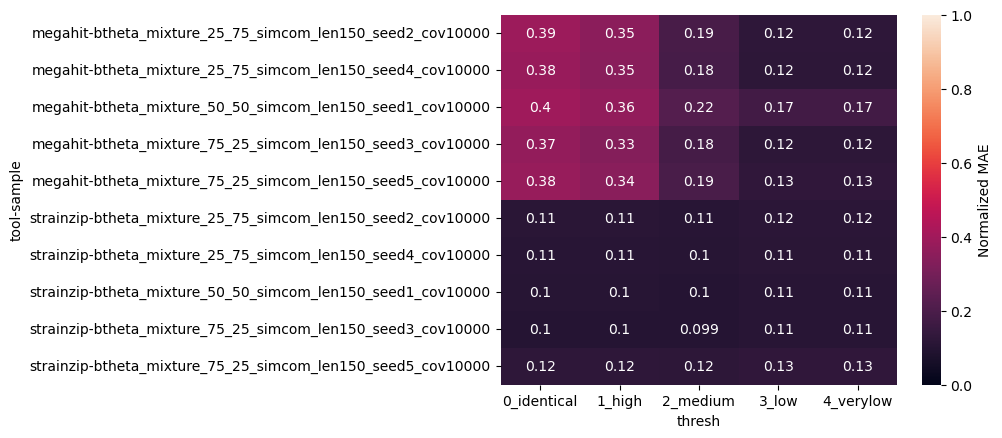

In [585]:
d = error.set_index(["tool", "sample", "thresh"]).sort_index().normalized_mae.unstack("thresh")
sns.heatmap(d, norm=mpl.colors.PowerNorm(1, vmin=0, vmax=1), cbar_kws=dict(label="Normalized MAE"), annot=d)

In [590]:
error = []
_min_identity, _min_coverage = 1.0, 0.9


match, weight = (
        match_strainzip.assign(key=lambda x: x.vertex),
        strainzip_normalized_depth,
    )

_selector = (
    lambda x: (x.identity >= _min_identity)
    & (x.qcoverage >= _min_coverage)
)

_ref_pred = predict_depth_from_match_and_weight(
    match=match_ref.assign(key=lambda x: x.genome),
    weight=sim_normalized_depth,
    selector=_selector,
)


_tool_pred = predict_depth_from_match_and_weight(
    match=match,
    weight=weight,
    selector=_selector,
)

x0, y0 = _ref_pred.align(_tool_pred, fill_value=0, join='left')

<Axes: xlabel='qseqid', ylabel='sample'>

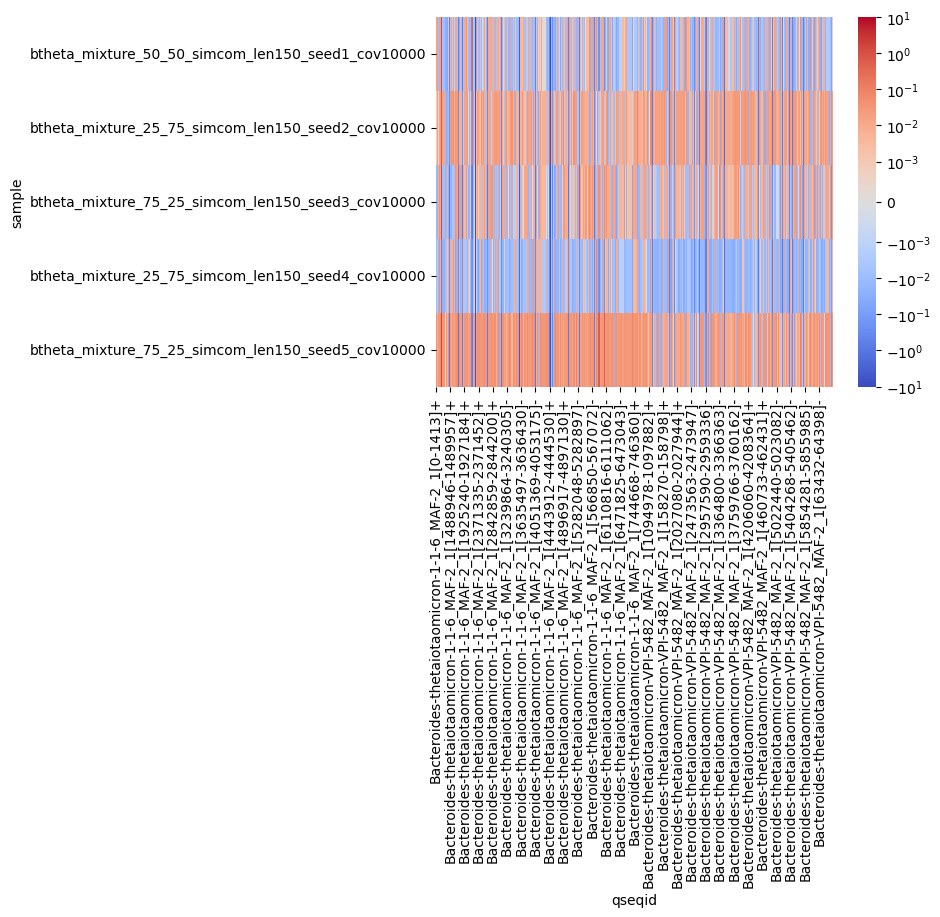

In [591]:
sns.heatmap(y0 - x0, norm=mpl.colors.SymLogNorm(1e-3, vmin=-10, vmax=10), cmap='coolwarm')

<Axes: xlabel='qseqid', ylabel='sample'>

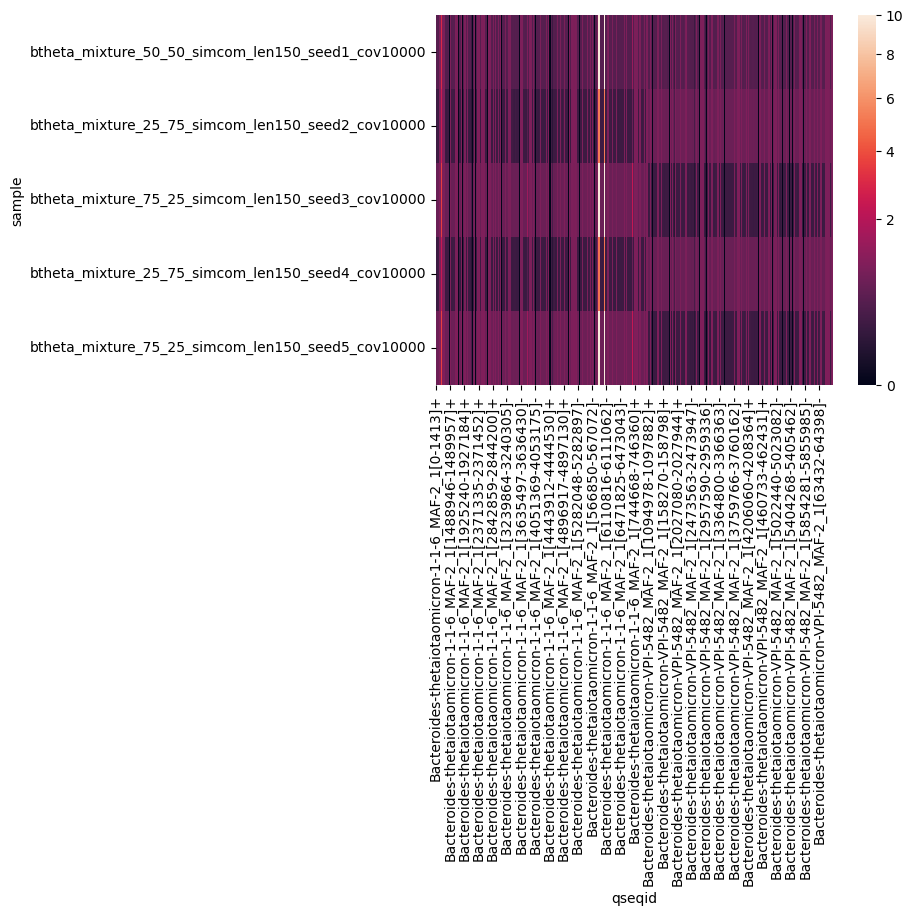

In [592]:
sns.heatmap(y0, norm=mpl.colors.PowerNorm(1/2, vmin=0, vmax=10))

<Axes: xlabel='qseqid', ylabel='sample'>

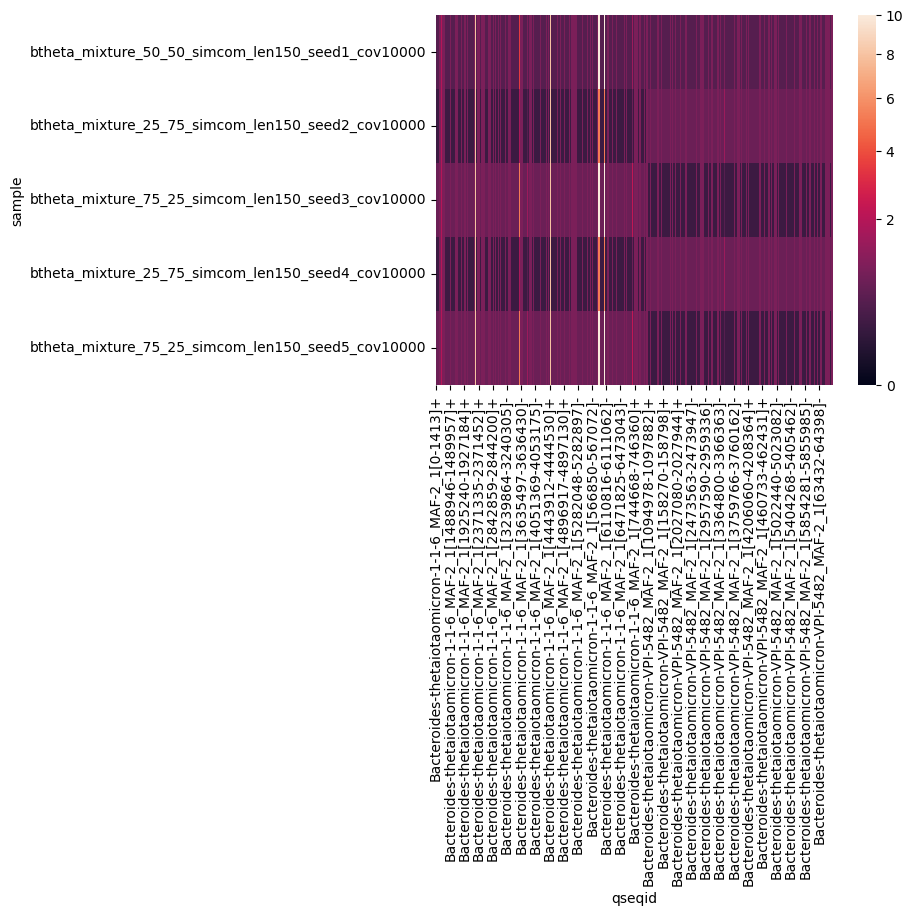

In [593]:
sns.heatmap(x0, norm=mpl.colors.PowerNorm(1/2, vmin=0, vmax=10))

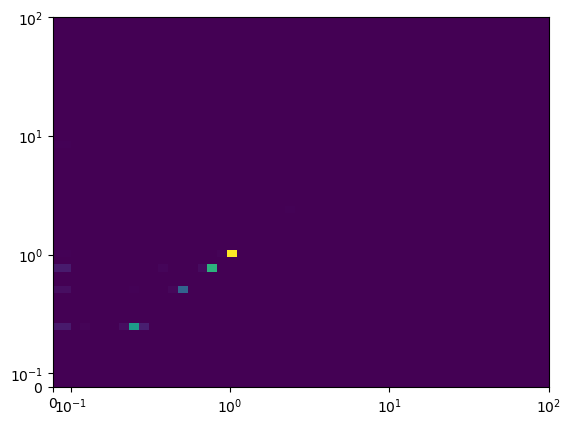

In [594]:
bins = [0] + list(np.logspace(-1, 2))
plt.hist2d(y0.values.flatten(), x0.values.flatten(), bins=bins)
plt.yscale('symlog', linthresh=1e-1, linscale=0.1)
plt.xscale('symlog', linthresh=1e-1, linscale=0.1)

#### Long Benchmark Sequences

<Axes: xlabel='thresh', ylabel='tool-sample'>

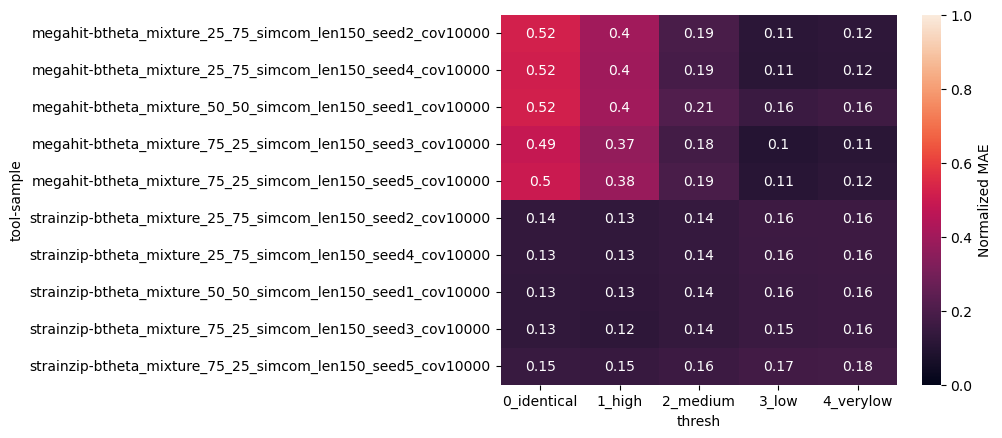

In [598]:
error = []
for thresh_name, _min_identity, _min_coverage in thresh_list:
    _selector = lambda x: (x.identity >= _min_identity) & (x.qcoverage >= _min_coverage) & (x.qlen > 2000)

    _ref_pred = predict_depth_from_match_and_weight(
        match=match_ref.assign(key=lambda x: x.genome),
        weight=sim_normalized_depth,
        selector=_selector,
    )

    for tool_name, match, weight in [
        (
            "strainzip",
            match_strainzip.assign(key=lambda x: x.vertex),
            strainzip_normalized_depth,
        ),
        (
            "megahit",
            match_megahit.assign(key=lambda x: x.vertex),
            megahit_normalized_depth,
        ),
    ]:
        _tool_pred = predict_depth_from_match_and_weight(
            match=match,
            weight=weight,
            selector=_selector,
        )

        x0, y0 = _ref_pred.align(_tool_pred, fill_value=0)
        for sample in x0.index:
            x1, y1 = x0.loc[sample], y0.loc[sample]
            error.append(
                dict(
                    sample=sample,
                    thresh=thresh_name,
                    min_coverage=_min_coverage,
                    min_identity=_min_identity,
                    tool=tool_name,
                    rsse=np.sqrt(np.sum(np.square(x1 - y1).values)),
                    rmse=np.sqrt(np.mean(np.square(x1 - y1).values)),
                    normalized_rmse=np.sqrt(np.mean(np.square(x1 - y1).values)) / np.sqrt(np.mean(np.square(x1))),
                    spearman=sp.stats.spearmanr(
                        x1.values.flatten(), y1.values.flatten()
                    ).statistic,
                    sae=np.sum(np.abs(x1 - y1).values),
                    mae=np.mean(np.abs(x1 - y1).values),
                    normalized_mae=np.sum(np.abs(x1 - y1).values) / np.sum(x1),
                    mean_resid=np.mean((x1 - y1).values),
                    frac_positive_resid=np.mean((x1 - y1).gt(0).values),
                    pearson=sp.stats.pearsonr(x1.values.flatten(), y1.values.flatten())[
                        0
                    ],
                )
            )

error = pd.DataFrame(error)

d = error.set_index(["tool", "sample", "thresh"]).sort_index().normalized_mae.unstack("thresh")
sns.heatmap(d, norm=mpl.colors.PowerNorm(1, vmin=0, vmax=1), cbar_kws=dict(label="Normalized MAE"), annot=d)

#### Short Benchmark Sequences

<Axes: xlabel='thresh', ylabel='tool-sample'>

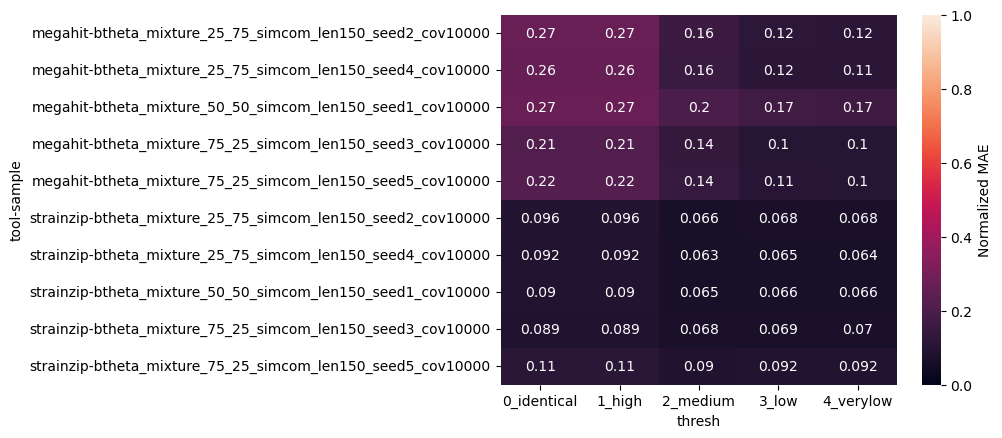

In [600]:
error = []
for thresh_name, _min_identity, _min_coverage in thresh_list:
    _selector = lambda x: (x.identity >= _min_identity) & (x.qcoverage >= _min_coverage) & (x.qlen < 500)

    _ref_pred = predict_depth_from_match_and_weight(
        match=match_ref.assign(key=lambda x: x.genome),
        weight=sim_normalized_depth,
        selector=_selector,
    )

    for tool_name, match, weight in [
        (
            "strainzip",
            match_strainzip.assign(key=lambda x: x.vertex),
            strainzip_normalized_depth,
        ),
        (
            "megahit",
            match_megahit.assign(key=lambda x: x.vertex),
            megahit_normalized_depth,
        ),
    ]:
        _tool_pred = predict_depth_from_match_and_weight(
            match=match,
            weight=weight,
            selector=_selector,
        )

        x0, y0 = _ref_pred.align(_tool_pred, fill_value=0)
        for sample in x0.index:
            x1, y1 = x0.loc[sample], y0.loc[sample]
            error.append(
                dict(
                    sample=sample,
                    thresh=thresh_name,
                    min_coverage=_min_coverage,
                    min_identity=_min_identity,
                    tool=tool_name,
                    rsse=np.sqrt(np.sum(np.square(x1 - y1).values)),
                    rmse=np.sqrt(np.mean(np.square(x1 - y1).values)),
                    normalized_rmse=np.sqrt(np.mean(np.square(x1 - y1).values)) / np.sqrt(np.mean(np.square(x1))),
                    spearman=sp.stats.spearmanr(
                        x1.values.flatten(), y1.values.flatten()
                    ).statistic,
                    sae=np.sum(np.abs(x1 - y1).values),
                    mae=np.mean(np.abs(x1 - y1).values),
                    normalized_mae=np.sum(np.abs(x1 - y1).values) / np.sum(x1),
                    mean_resid=np.mean((x1 - y1).values),
                    frac_positive_resid=np.mean((x1 - y1).gt(0).values),
                    pearson=sp.stats.pearsonr(x1.values.flatten(), y1.values.flatten())[
                        0
                    ],
                )
            )

error = pd.DataFrame(error)

d = error.set_index(["tool", "sample", "thresh"]).sort_index().normalized_mae.unstack("thresh")
sns.heatmap(d, norm=mpl.colors.PowerNorm(1, vmin=0, vmax=1), cbar_kws=dict(label="Normalized MAE"), annot=d)

#### One Strain

<Axes: xlabel='thresh', ylabel='tool-sample'>

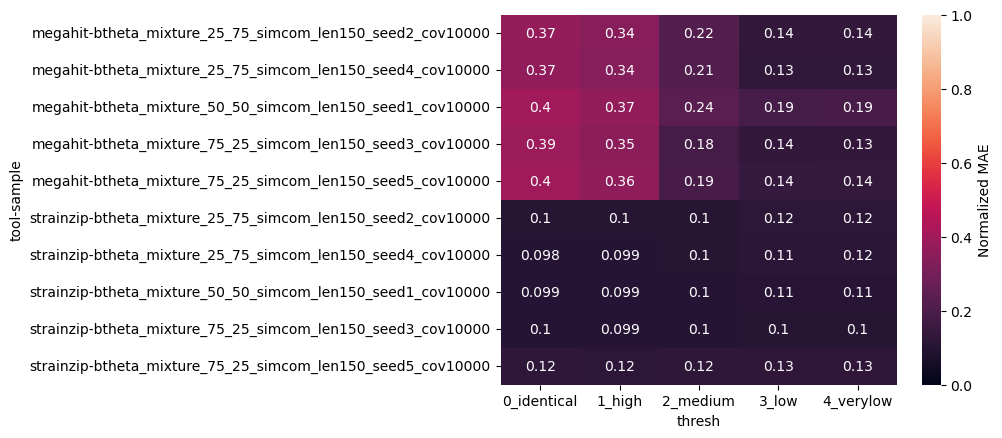

In [602]:
error = []
for thresh_name, _min_identity, _min_coverage in thresh_list:
    _selector = lambda x: (x.identity >= _min_identity) & (x.qcoverage >= _min_coverage) & x.qseqid.str.startswith('Bacteroides-thetaiotaomicron-1-1-6_MAF-2')

    _ref_pred = predict_depth_from_match_and_weight(
        match=match_ref.assign(key=lambda x: x.genome),
        weight=sim_normalized_depth,
        selector=_selector,
    )

    for tool_name, match, weight in [
        (
            "strainzip",
            match_strainzip.assign(key=lambda x: x.vertex),
            strainzip_normalized_depth,
        ),
        (
            "megahit",
            match_megahit.assign(key=lambda x: x.vertex),
            megahit_normalized_depth,
        ),
    ]:
        _tool_pred = predict_depth_from_match_and_weight(
            match=match,
            weight=weight,
            selector=_selector,
        )

        x0, y0 = _ref_pred.align(_tool_pred, fill_value=0)
        for sample in x0.index:
            x1, y1 = x0.loc[sample], y0.loc[sample]
            error.append(
                dict(
                    sample=sample,
                    thresh=thresh_name,
                    min_coverage=_min_coverage,
                    min_identity=_min_identity,
                    tool=tool_name,
                    rsse=np.sqrt(np.sum(np.square(x1 - y1).values)),
                    rmse=np.sqrt(np.mean(np.square(x1 - y1).values)),
                    normalized_rmse=np.sqrt(np.mean(np.square(x1 - y1).values)) / np.sqrt(np.mean(np.square(x1))),
                    spearman=sp.stats.spearmanr(
                        x1.values.flatten(), y1.values.flatten()
                    ).statistic,
                    sae=np.sum(np.abs(x1 - y1).values),
                    mae=np.mean(np.abs(x1 - y1).values),
                    normalized_mae=np.sum(np.abs(x1 - y1).values) / np.sum(x1),
                    mean_resid=np.mean((x1 - y1).values),
                    frac_positive_resid=np.mean((x1 - y1).gt(0).values),
                    pearson=sp.stats.pearsonr(x1.values.flatten(), y1.values.flatten())[
                        0
                    ],
                )
            )

error = pd.DataFrame(error)

d = error.set_index(["tool", "sample", "thresh"]).sort_index().normalized_mae.unstack("thresh")
sns.heatmap(d, norm=mpl.colors.PowerNorm(1, vmin=0, vmax=1), cbar_kws=dict(label="Normalized MAE"), annot=d)

#### Other Strain

<Axes: xlabel='thresh', ylabel='tool-sample'>

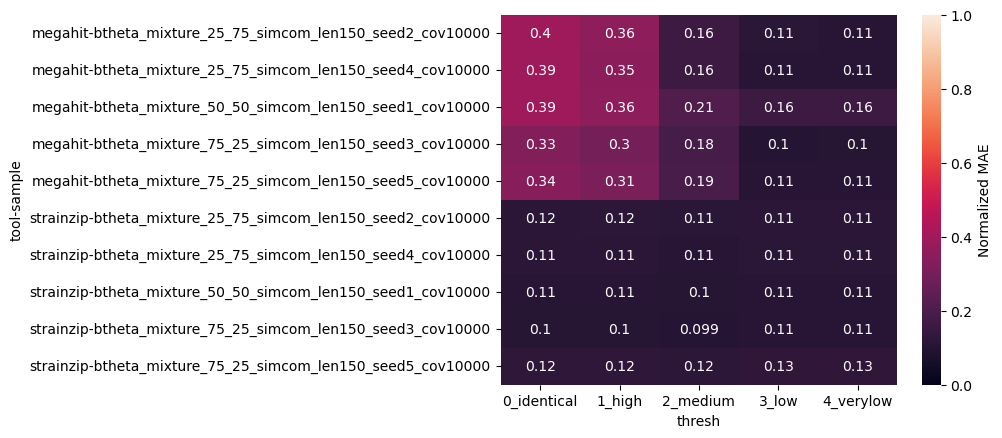

In [604]:
error = []
for thresh_name, _min_identity, _min_coverage in thresh_list:
    _selector = lambda x: (x.identity >= _min_identity) & (x.qcoverage >= _min_coverage) & x.qseqid.str.startswith('Bacteroides-thetaiotaomicron-VPI-5482_MAF-2')

    _ref_pred = predict_depth_from_match_and_weight(
        match=match_ref.assign(key=lambda x: x.genome),
        weight=sim_normalized_depth,
        selector=_selector,
    )

    for tool_name, match, weight in [
        (
            "strainzip",
            match_strainzip.assign(key=lambda x: x.vertex),
            strainzip_normalized_depth,
        ),
        (
            "megahit",
            match_megahit.assign(key=lambda x: x.vertex),
            megahit_normalized_depth,
        ),
    ]:
        _tool_pred = predict_depth_from_match_and_weight(
            match=match,
            weight=weight,
            selector=_selector,
        )

        x0, y0 = _ref_pred.align(_tool_pred, fill_value=0)
        for sample in x0.index:
            x1, y1 = x0.loc[sample], y0.loc[sample]
            error.append(
                dict(
                    sample=sample,
                    thresh=thresh_name,
                    min_coverage=_min_coverage,
                    min_identity=_min_identity,
                    tool=tool_name,
                    rsse=np.sqrt(np.sum(np.square(x1 - y1).values)),
                    rmse=np.sqrt(np.mean(np.square(x1 - y1).values)),
                    normalized_rmse=np.sqrt(np.mean(np.square(x1 - y1).values)) / np.sqrt(np.mean(np.square(x1))),
                    spearman=sp.stats.spearmanr(
                        x1.values.flatten(), y1.values.flatten()
                    ).statistic,
                    sae=np.sum(np.abs(x1 - y1).values),
                    mae=np.mean(np.abs(x1 - y1).values),
                    normalized_mae=np.sum(np.abs(x1 - y1).values) / np.sum(x1),
                    mean_resid=np.mean((x1 - y1).values),
                    frac_positive_resid=np.mean((x1 - y1).gt(0).values),
                    pearson=sp.stats.pearsonr(x1.values.flatten(), y1.values.flatten())[
                        0
                    ],
                )
            )

error = pd.DataFrame(error)

d = error.set_index(["tool", "sample", "thresh"]).sort_index().normalized_mae.unstack("thresh")
sns.heatmap(d, norm=mpl.colors.PowerNorm(1, vmin=0, vmax=1), cbar_kws=dict(label="Normalized MAE"), annot=d)